# EE5907/EE5027 Programming Assignment CA1

> by: SUN Shuo A0162488U
> 
> "You may just run the code blocks all the way till the end"

## Data Processing

In [1]:
%matplotlib inline
import scipy.io
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load mat data
mat_data = scipy.io.loadmat('data/spamData.mat')
#print(mat_data)
x_train = mat_data['Xtrain']
y_train = mat_data['ytrain']
x_test = mat_data['Xtest']
y_test = mat_data['ytest']

#x_train = np.array([(1,0), (1,1), (0,0)]).reshape(-1,2)
#y_train = np.array([1, 1, 0]).reshape(-1,1)
#x_test = np.array([(1,0), (1,0)]).reshape(-1,2)
#y_test = np.array([1, 1]).reshape(-1,1)

# Check data shapes and types
print("X train", type(x_train), "shape:", x_train.shape, "dtype:", x_train.dtype)
print("y train", type(y_train), "shape:", y_train.shape, "dtype:", y_train.dtype)
print("X test", type(x_test), "shape:", x_test.shape, "dtype:", x_test.dtype)
print("y test", type(y_test), "shape:", y_test.shape, "dtype:", y_test.dtype)

# Binarization 
x_train_bin = (x_train > 0) * 1
x_test_bin = (x_test > 0) * 1
#print(x_train_bin)
#print(x_test_bin)

# Log Transform
x_train_log = np.log(x_train + 0.1)
x_test_log = np.log(x_test + 0.1)
#print(x_train_log)
#print(x_test_log)

X train <class 'numpy.ndarray'> shape: (3065, 57) dtype: float64
y train <class 'numpy.ndarray'> shape: (3065, 1) dtype: uint8
X test <class 'numpy.ndarray'> shape: (1536, 57) dtype: float64
y test <class 'numpy.ndarray'> shape: (1536, 1) dtype: uint8


## Q1. Beta-binomial Naive Bayes (24%)

In [123]:
def beta(N, N_1, a, b):
    """
    Compute the Beta(`alpha`, `alpha`) distribution
    """
    if (N + a + b) > 0:
        return (N_1 + a)/(N + a + b)
    else:
        return 0

def featureLikelihood(X_train, Y_train, j, x_j, c, alpha):
    """
    Compute the feature likelihood term for one (x_test, y_test=c) data point
    Class: `c`, Feature: `j`: p(x_test_j| x_i_j, y_test=c)
    """
    N = (Y_train == c).sum()
    X_train_j = X_train[:, j].reshape(-1, 1)
    N_1 = (X_train_j[Y_train == c] == 1).sum()
    #print("N:", N, "N_1:", N_1)
    
    if x_j == 1:
        return beta(N, N_1, alpha, alpha)
    else:
        return 1 - beta(N, N_1, alpha, alpha)

def posteriorPredictiveDistribution(X_train, Y_train, X_test, i, c, alpha):
    """
    Compute the posterior predictive distribution of test feature
    SUM of log(p(x_test_j | x_i_j, y_test=c))
    """
    p_sum = 0
    # For its j-th feature
    for j in range(X_test.shape[1]):
        p = featureLikelihood(X_train, Y_train, j, X_test[i][j], c, alpha)
        if p > 0:
            p_sum += np.log(p)
        #print("Term(", i, ",", j, ") is:", p)
            
    return p_sum
    
def betaBinomialNaiveBayes(X_train, Y_train, X_test, alpha):
    """
    Fit a Beta Binomial Naive Bayes Classifier on the `X_train`, `Y_train` data,
    and predict the results `Y_pred` with the given `alpha`
    """
    # Class label prior lambda
    lambda_ml = (Y_train == 1).sum() / Y_train.shape[0]
    #print("lambda_ml:", lambda_ml)
    
    Y_pred = np.zeros((X_test.shape[0], 1), dtype=int)
    # For the i-th test data
    for i in range(Y_pred.shape[0]):
        P_0 = np.log(1 - lambda_ml) + posteriorPredictiveDistribution(X_train, Y_train, X_test, i, 0, alpha)
        P_1 = np.log(lambda_ml) + posteriorPredictiveDistribution(X_train, Y_train, X_test, i, 1, alpha)
        #print(P_0)
        #print(P_1)
        if P_0 < P_1:
            Y_pred[i][0] = 1
        #print(Y_pred)
        #print("y predict", type(Y_pred), "shape:", Y_pred.shape, "dtype:", Y_pred.dtype)
    
    return Y_pred

def computeErrorRate(X_train, Y_train, X_test, Y_test, alpha):
    """
    Compute the Error Rate based on the `Y_pred` result and the given ground truth `Y_test`, 
    with a given alpha values
    """
    Y_pred = betaBinomialNaiveBayes(X_train, Y_train, X_test, alpha)
    num_error = (Y_pred != Y_test).sum()
    
    return num_error/Y_test.shape[0]
    
def compareAlphas(X_train, Y_train, X_test, Y_test, alphas):
    """
    Compute the Error Rate based on the `Y_pred` result and the given ground truth `Y_test`, 
    with varying alpha values
    """
    error_rates = np.zeros((alphas.shape[0], 1))
    for i in tqdm(range(alphas.shape[0])):
        error_rates[i] = computeErrorRate(X_train, Y_train, X_test, Y_test, alphas[i])
        
    return error_rates
    

### Compute and Plot Results

In [ ]:
# Set experimenting alpha values
alphas = np.arange(0, 100.5, 0.5)
print("Plotting error rates on the training set:")
train_error_rates = compareAlphas(x_train_bin, y_train, x_train_bin, y_train, alphas)
print("Plotting error rates on the test set:")
test_error_rates = compareAlphas(x_train_bin, y_train, x_test_bin, y_test, alphas)

# Plotting
fig, ax = plt.subplots()
line1, = ax.plot(alphas, train_error_rates, label='training')
line2, = ax.plot(alphas, test_error_rates, dashes=[6, 2], label='test')

ax.set(xlabel='α', ylabel='error rate', title='Q1. Beta-binomial Naive Bayes')
ax.legend()
ax.grid()

fig.savefig("pics/q1.png")
plt.show()

# Print some results
print("On the training set, the error rates for α = 1, 10, 100 are respectively:", 
      train_error_rates[2], ",", train_error_rates[20], ",", train_error_rates[-1])
print("On the test set, the error rates for α = 1, 10, 100 are respectively:", 
      test_error_rates[2], ",", test_error_rates[20], ",", test_error_rates[-1])

Plotting error rates on the training set:


  0%|                                                                                 | 0/201 [00:00<?, ?it/s]

## Q2. Gaussian Naive Bayes (24%)

In [17]:
def gaussian(x, mu, sigma_sq):
    """
    Compute the gaussian(`mu`, `sigma_sq`) distribution of `x`
    """
    if sigma_sq > 0:
        return 1/np.sqrt(2*np.pi*sigma_sq) * np.exp(-0.5*np.power((x - mu), 2)/sigma_sq)
    else:
        return 0
    
def paramMLEstimate(X_train, Y_train, c):
    """
    Compute the ML estimate of `mean` and `var` for each feature
    """
    row_idxs = []
    for i in range(Y_train.shape[0]):
        if Y_train[i][0] == c:
            row_idxs.append(i)
    X_train_c = X_train[np.array(row_idxs), :]
    #print("X_train_c:", X_train_c.shape)
    mean = np.mean(X_train_c, axis=0)
    var = np.var(X_train_c, axis=0)
    #print("Mean:", mean[0], "shape:", mean.shape)
    #print("Var:", var[0], "shape:", var.shape)
    
    return mean, var
    
def featureLikelihood(x_j, mu, sigma_sq):
    """
    Compute the feature likelihood term for one (x_test, y_test=c) data point
    Class: `c`, Feature: `j`: p(x_test_j| x_i_j, y_test=c)
    """
    
    return gaussian(x_j, mu, sigma_sq)
    
def sumFeatureLikelihood(X_test, Means, Vars, i, c):
    """
    Compute the sum of test feature likelihood:
    SUM(log(p(x_test_j | x_i_j, y_test=c)))
    """
    p_sum = 0
    for j in range(X_test.shape[1]):
        p_sum += np.log(featureLikelihood(X_test[i][j], Means[c][j], Vars[c][j]))
        
    return p_sum

def GaussianNaiveBayes(X_train, Y_train, X_test):
    """
    Fit a Beta Binomial Naive Bayes Classifier on the `X_train`, `Y_train` data,
    and predict the results `Y_pred` with the given `alpha`
    """
    # Class label prior lambda
    lambda_ml = (Y_train == 1).sum() / Y_train.shape[0]
    #print("lambda_ml:", lambda_ml)
    Means = np.zeros((2, X_train.shape[1]))
    Vars = np.zeros((2, X_train.shape[1]))
    for i in range(2):
        Means[i], Vars[i] = paramMLEstimate(X_train, Y_train, i)
    #print("Means:", Means, "shape:", Means.shape)
    #print("Vars:", Vars, "shape:", Vars.shape)
    
    Y_pred = np.zeros((X_test.shape[0], 1), dtype=int)
    # For the i-th test data
    for i in range(Y_pred.shape[0]):
        P_0 = np.log(1 - lambda_ml) + sumFeatureLikelihood(X_test, Means, Vars, i, 0)
        P_1 = np.log(lambda_ml) + sumFeatureLikelihood(X_test, Means, Vars, i, 1)
        #print(P_0)
        #print(P_1)
        if P_0 < P_1:
            Y_pred[i][0] = 1
            
    #print(Y_pred)
    #print("y predict", type(Y_pred), "shape:", Y_pred.shape, "dtype:", Y_pred.dtype)
    
    return Y_pred

def computeErrorRate(X_train, Y_train, X_test, Y_test):
    """
    Compute the Error Rate based on the `Y_pred` result and the given ground truth `Y_test`
    """
    Y_pred = GaussianNaiveBayes(X_train, Y_train, X_test)
    num_error = (Y_pred != Y_test).sum()
    
    return num_error/Y_test.shape[0]

### Compute Results

In [ ]:
# Compute the train and test error rate
train_error_rate = computeErrorRate(x_train_log, y_train, x_train_log, y_train)
test_error_rate = computeErrorRate(x_train_log, y_train, x_test_log, y_test)

# Print some results
print("On the training set, the error rate is:", train_error_rate)
print("On the test set, the error rate is:", test_error_rate)

## Q3. Logistic regression (24%)

In [62]:
def sigmoid(x):
    """
    Compute the sigmoid(`x`)
    """
    return 1/(1 + np.exp(-x))

def mu(w, X):
    """
    Compute the sigmoid(`-w^Tx`) for N feature vectors
    """
    mu_ = []
    for i in range(X.shape[0]):
        mu_.append(sigmoid(np.transpose(w).dot(X[i])))
        
    return np.array(mu_)

def NLL(w, X, Y):
    """
    Compute the Negative Log Likelihood, NLL(`w`)
    """
    nll_sum = 0
    mu_ = mu(w, X)
    for i in range(Y.shape[0]):
        nll_sum += Y[i]*np.log(mu[i]) + (1 - Y[i])*np.log(1 - mu[i])
        
    return -nll_sum

def NLLReg(w_, X_, Y, _lambda):
    """
    Compute the Negative Log Likelihood with l2 regularization, NLL_reg(`w_`)
    """
    return NLL(w_, X_, Y) + 0.5*_lambda*np.transpose(w_).dot(w_)

def g(mu_, X_, Y):
    """
    Compute NLL's first derivatives `g`
    """
    return np.transpose(X_).dot(mu_ - Y)

def hessian(mu_, X_):
    """
    Compute NLL's second derivatives, the Hessian Matrix `H`
    """
    for i in range(mu_.shape[0]):
        mu_[i] = mu_[i]*(1 - mu_[i])
    S = np.diag(mu_.reshape(mu_.shape[0]))

    return np.transpose(X_).dot(S).dot(X_)

def newtonsMethod(w, X, Y, k_max, _lambda, eta, tolerance):
    """
    Optimization with Newton's Method
    """
    w_ = np.insert(w, 0, 0.0, axis=0)
    X_ = np.insert(X, 0, 1.0, axis=1)
    w_curr = w_
    
    diag_v = np.ones(w_.shape[0])
    diag_v[0] = 0.0
    
    for i in range(k_max):
        v = np.copy(w_curr)
        v[0] = 0.0
        mu_ = mu(w_curr, X_)
        g_reg = g(mu_, X_, Y) + _lambda*v
        H_reg = hessian(mu_, X_) + _lambda*np.diag(diag_v)
        d = np.linalg.inv(H_reg).dot(-g_reg)
        
        if np.average((d/w_curr)) < tolerance:
            # print("Optimization finished at iteration:", i)
            break
        else:
            w_next = w_curr + eta*d
            w_curr = w_next
        
    return w_next

def logisticRegressionPredict(w_, X_test):
    """
    Predict the results `Y_pred` based on the given weights `w_`
    """
    X_ = np.insert(X_test, 0, 1.0, axis=1)
    # Start Prediction
    mu_test = mu(w_, X_)
    Y_pred = np.zeros((X_test.shape[0], 1), dtype=int)
    for i in range(mu_test.shape[0]):
        P_1 = np.log(mu_test[i])
        P_0 = np.log(1 - mu_test[i])
        if P_1 > P_0:
            Y_pred[i][0] = 1

    return Y_pred

def computeErrorRate(w_, X_test, Y_test):
    """
    Compute the Error Rate based on the `Y_pred` result and the given ground truth `Y_test`, 
    with a given alpha values
    """
    Y_pred = logisticRegressionPredict(w_, X_test)
    num_error = (Y_pred != Y_test).sum()
    return num_error/Y_test.shape[0]

def compareLambdas(X_train, Y_train, X_test, Y_test, lambdas, lr, tol, k_max):
    """
    Compute the Error Rate based on the `Y_pred` result and the given ground truth `Y_test`, 
    with varying lambda values
    """
    train_error_rates = np.zeros((lambdas.shape[0], 1))
    test_error_rates = np.zeros((lambdas.shape[0], 1))
    for i in tqdm(range(lambdas.shape[0])):
        # Start Training
        w = np.zeros((x_train_log.shape[1], 1))
        w = newtonsMethod(w, x_train_log, y_train, k_max, lambdas[i], lr, tolerance)
        # Start Prediction
        train_error_rates[i] = computeErrorRate(w, X_train, Y_train)
        test_error_rates[i] = computeErrorRate(w, X_test, Y_test)
        
    return train_error_rates, test_error_rates
    

### Train, Predict and Plot

[  1   2   3   4   5   6   7   8   9  10  15  20  25  30  35  40  45  50
  55  60  65  70  75  80  85  90  95 100]
Plotting error rates...


  0%|                                                                                  | 0/28 [00:00<?, ?it/s]/var/folders/fg/jctl91s50mlb_ynfb3z_7xx80000gn/T/ipykernel_25647/4069521022.py:69: RuntimeWarning: divide by zero encountered in true_divide
  if np.average((d/w_curr)) < tolerance:
/Users/ss/opt/anaconda3/envs/pr/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
100%|█████████████████████████████████████████████████████████████████████████| 28/28 [01:42<00:00,  3.64s/it]


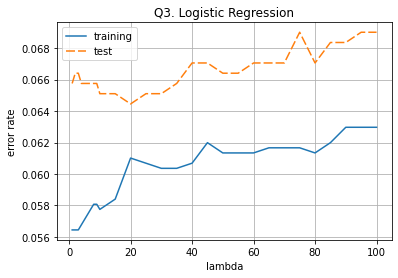

On the training set, the error rates for α = 1, 10, 100 are respectively: [0.05644372] , [0.05774878] , [0.062969]
On the test set, the error rates for α = 1, 10, 100 are respectively: [0.06575521] , [0.06510417] , [0.06901042]


In [66]:
# Hyperparameters
lr = 0.01
tol = 1e-6
k_max = 1000

# Set experimenting lambda values
lambdas = np.concatenate((np.arange(1, 10, 1), np.arange(10, 105, 5)), axis=None)
print(lambdas)

print("Plotting error rates...")
train_error_rates, test_error_rates = compareLambdas(x_train_log, y_train, x_test_log, y_test, lambdas, lr, tol, k_max)

# Plotting
fig, ax = plt.subplots()
line1, = ax.plot(lambdas, train_error_rates, label='training')
line2, = ax.plot(lambdas, test_error_rates, dashes=[6, 2], label='test')

ax.set(xlabel='λ', ylabel='error rate', title='Q3. Logistic Regression')
ax.legend()
ax.grid()

fig.savefig("pics/q3.png")
plt.show()

# Print some results
print("On the training set, the error rates for λ = 1, 10, 100 are respectively:", 
      train_error_rates[0], ",", train_error_rates[9], ",", train_error_rates[-1])
print("On the test set, the error rates for λ = 1, 10, 100 are respectively:", 
      test_error_rates[0], ",", test_error_rates[9], ",", test_error_rates[-1])

## Q4. K-Nearest Neighbors (24%)

In [120]:
def euclideaniDist(a, b):
    """
    Compute the euclidean distance between two feature vectors
    """
    dist = 0
    for j in range(a.shape[0]):
        dist += np.power((a[j] - b[j]), 2)
        
    return np.sqrt(dist)

def sortNN(X_train, Y_train, x_test):
    """
    sort the training data based on the euclidean distance to the test data `x_test`
    """
    dists = []
    for i in range(X_train.shape[0]):
        dists.append(euclideaniDist(X_train[i], x_test))
    idxs = np.argsort(np.array(dists))
    return idxs

def KNNPredict(X_train, Y_train, X_test, Ks):
    """
    Predict class labels for `X_test` using `K` Nearest Neighbors 
    """
    Y_pred = np.zeros((X_test.shape[0], Ks.shape[0]), dtype=int)
    # loop through all test data
    for i in tqdm(range(X_test.shape[0])):
        idxs = sortNN(X_train, Y_train, X_test[i])

        # for each K value, estimate the resulted class labels
        for k in range(Ks.shape[0]):
            k_1 = (Y_train[idxs[:Ks[k]]] == 1).sum()
            P_1 = k_1/Ks[k]
            if P_1 > 0.5:
                Y_pred[i][k] = 1
            
    return Y_pred
    
def computeErrorRate(X_train, Y_train, X_test, Y_test, Ks):
    """
    Compute the Error Rate based on the `Y_pred` result and the given ground truth `Y_test`, 
    with a given K value
    """
    error_rates = np.zeros((Ks.shape[0], 1))
    Y_pred = KNNPredict(X_train, Y_train, X_test, Ks)
    
    for k in tqdm(range(Ks.shape[0])):
        y_pred = Y_pred[:, k].reshape(-1, 1)
        num_error = (y_pred != Y_test).sum()
        #print("y_pred", y_pred)
        error_rates[k] = num_error/Y_test.shape[0]
    
    return error_rates

### Predict and Plot Results

K values: [  1   2   3   4   5   6   7   8   9  10  15  20  25  30  35  40  45  50
  55  60  65  70  75  80  85  90  95 100]
Plotting error rates...


100%|██████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 15810.52it/s]


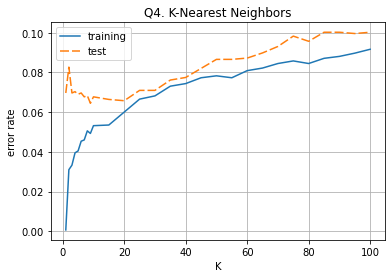

On the training set, the error rates for K = 1, 10, 100 are respectively: [0.00065253] , [0.05318108] , [0.09168026]
On the test set, the error rates for K = 1, 10, 100 are respectively: [0.06966146] , [0.06770833] , [0.10026042]


In [121]:
# Set experimenting lambda values
Ks = np.concatenate((np.arange(1, 10, 1), np.arange(10, 105, 5)), axis=None)
print("K values:", Ks)

print("Plotting error rates...")
train_error_rates = computeErrorRate(x_train_log, y_train, x_train_log, y_train, Ks)
test_error_rates = computeErrorRate(x_train_log, y_train, x_test_log, y_test, Ks)

# Plotting
fig, ax = plt.subplots()
line1, = ax.plot(Ks, train_error_rates, label='training')
line2, = ax.plot(Ks, test_error_rates, dashes=[6, 2], label='test')

ax.set(xlabel='K', ylabel='error rate', title='Q4. K-Nearest Neighbors')
ax.legend()
ax.grid()

fig.savefig("pics/q4.png")
plt.show()

# Print some results
print("On the training set, the error rates for K = 1, 10, 100 are respectively:", 
      train_error_rates[0], ",", train_error_rates[9], ",", train_error_rates[-1])
print("On the test set, the error rates for K = 1, 10, 100 are respectively:", 
      test_error_rates[0], ",", test_error_rates[9], ",", test_error_rates[-1])